### Forcasting AQI with LSTM

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [81]:
df = pd.read_csv("/home/kkyu/amr_ws/DL/IoT_Project/environment.csv")
df

,Date,Temperature (°C),Humidity (%),CO2 (PPM),PM-10 (μg/m3)
0,2024-03-10 13:01:38,26.2,23.0,294,11.36
1,2024-03-10 13:01:40,26.2,23.0,293,20.16
2,2024-03-10 13:01:42,26.2,23.0,290,23.09
3,2024-03-10 13:01:44,26.2,23.0,288,22.11
4,2024-03-10 13:01:48,26.2,23.0,285,26.02
...,...,...,...,...,...
1727,2024-03-10 13:59:32,22.6,18.0,124,27.00
1728,2024-03-10 13:59:34,22.6,18.0,125,20.16
1729,2024-03-10 13:59:36,22.6,18.0,124,33.84
1730,2024-03-10 13:59:38,22.6,18.0,125,27.98


In [82]:
print(df.isnull().sum())

Date                0
Temperature (°C)    0
Humidity (%)        0
CO2 (PPM)           0
PM-10 (μg/m3)       0
dtype: int64


In [83]:
# 'AQI' 컬럼 생성
df['AQI'] = 0

# for loop를 사용하여 각 행에 대한 AQI 값 계산 및 할당
for index, row in df.iterrows():
    PM_10_value = row['PM-10 (μg/m3)']
    AQI_value = ((100 - 51) / (80 - 31)) * (PM_10_value - 31) + 51
    df.at[index, 'AQI'] = AQI_value

df.head()

/tmp/ipykernel_40598/3340056854.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '31.36' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'AQI'] = AQI_value


,Date,Temperature (°C),Humidity (%),CO2 (PPM),PM-10 (μg/m3),AQI
0,2024-03-10 13:01:38,26.2,23.0,294,11.36,31.36
1,2024-03-10 13:01:40,26.2,23.0,293,20.16,40.16
2,2024-03-10 13:01:42,26.2,23.0,290,23.09,43.09
3,2024-03-10 13:01:44,26.2,23.0,288,22.11,42.11
4,2024-03-10 13:01:48,26.2,23.0,285,26.02,46.02


In [84]:
# 'AQI_Bucket' 컬럼 생성 및 값 할당
df['AQI_Bucket'] = pd.cut(df['AQI'], bins=[0, 50, 100, 250, 500], labels=['Good', 'Moderate', 'Unhealthy', 'Very Unhealthy'])

df.head()

,Date,Temperature (°C),Humidity (%),CO2 (PPM),PM-10 (μg/m3),AQI,AQI_Bucket
0,2024-03-10 13:01:38,26.2,23.0,294,11.36,31.36,Good
1,2024-03-10 13:01:40,26.2,23.0,293,20.16,40.16,Good
2,2024-03-10 13:01:42,26.2,23.0,290,23.09,43.09,Good
3,2024-03-10 13:01:44,26.2,23.0,288,22.11,42.11,Good
4,2024-03-10 13:01:48,26.2,23.0,285,26.02,46.02,Good


In [85]:
# 필요한 feature 선택
features = ['Temperature (°C)', 'Humidity (%)', 'CO2 (PPM)', 'PM-10 (μg/m3)']

# 데이터 스케일링
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [86]:
# 데이터 스케일링
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# X와 y 분리
X = scaled_data
y = df['AQI']

# LSTM 입력 형태로 변환
X = X.reshape(X.shape[0], 1, X.shape[1])

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
# LSTM 모델 구성
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

In [88]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

In [89]:
# 모델 훈련
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
44/44 [==============================] - 3s 18ms/step - loss: 8929.5000 - val_loss: 10679.4102
Epoch 2/50
44/44 [==============================] - 0s 6ms/step - loss: 8806.9346 - val_loss: 10408.7568
Epoch 3/50
44/44 [==============================] - 0s 7ms/step - loss: 8368.4150 - val_loss: 9816.6660
Epoch 4/50
44/44 [==============================] - 0s 6ms/step - loss: 7860.1855 - val_loss: 9376.8701
Epoch 5/50
44/44 [==============================] - 0s 5ms/step - loss: 7513.7139 - val_loss: 9091.5820
Epoch 6/50
44/44 [==============================] - 0s 5ms/step - loss: 7280.2485 - val_loss: 8879.1211
Epoch 7/50
44/44 [==============================] - 0s 5ms/step - loss: 7104.5688 - val_loss: 8715.1182
Epoch 8/50
44/44 [==============================] - 0s 5ms/step - loss: 6964.0239 - val_loss: 8580.6055
Epoch 9/50
44/44 [==============================] - 0s 6ms/step - loss: 6844.0532 - val_loss: 8466.9971
Epoch 10/50
44/44 [==============================] - 0s 5ms/s

In [90]:

# 테스트 데이터로 예측
y_pred = model.predict(X_test)

11/11 [==============================] - 1s 2ms/step


In [91]:
# 예측값과 실제값 비교
comparison_df = pd.DataFrame({'Actual AQI': y_test.values, 'Predicted AQI': y_pred.reshape(-1)})
print(comparison_df)

     Actual AQI  Predicted AQI
0         36.25      53.954506
1         47.98      52.449459
2         49.93      53.958206
3         38.20      53.186165
4         67.53      52.796604
..          ...            ...
342       56.77      53.941719
343       47.98      53.201588
344       30.38      53.949554
345       27.45      53.957355
346       39.18      53.949776

[347 rows x 2 columns]


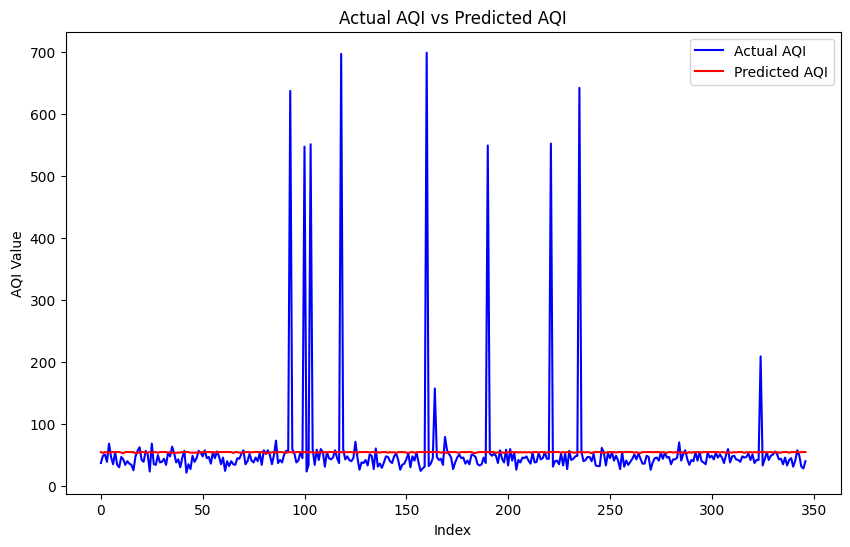

In [92]:
# 실제 AQI와 예측된 AQI 추출
actual_aqi = comparison_df['Actual AQI']
predicted_aqi = comparison_df['Predicted AQI']

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(actual_aqi, label='Actual AQI', color='blue')
plt.plot(predicted_aqi, label='Predicted AQI', color='red')
plt.title('Actual AQI vs Predicted AQI')
plt.xlabel('Index')
plt.ylabel('AQI Value')
plt.legend()
plt.show()
